In [1]:
import sys, os
import numpy as np
import pandas as pd
from scipy.integrate import quad, dblquad, simpson
from matplotlib import pyplot as plt
from matplotlib import rc
plt.style.use('bmh')
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

run = False

In [2]:
energ = np.loadtxt('events.txt', comments='#')
energ = sorted(energ)
kamland = pd.DataFrame(data=sorted(energ), columns=['nu energy (MeV)'])
kamland

,nu energy (MeV)
0,2.61
1,2.62
2,2.62
3,2.63
4,2.64
...,...
253,6.46
254,6.86
255,6.90
256,7.85


In [3]:
bins = np.linspace(2.6, 2.6 + 0.425*13, 14)
midbins = (bins[1:] + bins[:-1]) / 2
def vcount(arr, bins):
    digi = np.digitize(arr, bins)
    counts = []
    for b in range(1, len(bins)):
        counts.append(len([d for d in digi if d == b]))
    return np.array(counts)
energ_vc = vcount(energ, bins)

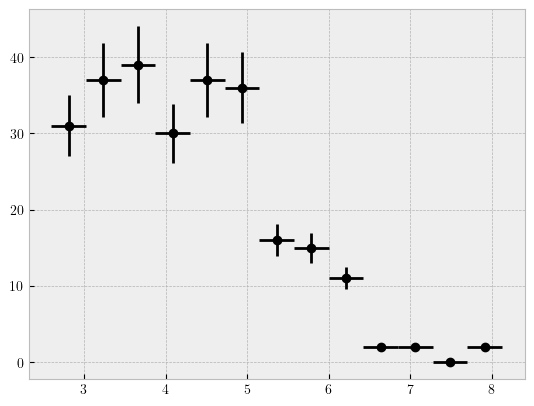

In [4]:
#plt.hist(energ, bins=np.linspace(2.6,2.6+0.425*13,14), histtype='step', linewidth=2)  # histtype = step
plt.errorbar(midbins, energ_vc, xerr=0.425/2, yerr=0.13*energ_vc, marker='o', linestyle='', color='k')
plt.show()

## Number of events at the detector
reference: JUNO’s prospects for determining
the neutrino mass ordering

The number of events, $N_i$, in the $i$-th bin
corresponding to the reconstructed neutrino energy $E_i$ is given by

$$
N_i = \mathcal{N}_\mathcal{T}
\int dE \int_{E_i^{\text{min}}}^{E_i^{\text{max}}} dE'
\phi (E) P_{\nu_e \to \nu_e}(E, L) \sigma(E)
R(E, E_i').
$$
onde
$$
\mathcal{N}_\mathcal{T} = n_p \epsilon \mathcal{T}
$$
é a constante que leva em conta o tempo de exposição $\mathcal{T}$, a eficiência do detector $\epsilon$ e o número de target prótons $n_p$ (massa fiducial).

### Energy resolution function
$$
R(E, E') = \frac{1}{\sigma_E(E) \, \sqrt{2\pi}}
\exp\left(-\frac{(E-E')^2}{2\sigma^2_E(E)}\right),
$$
onde a resolução de energia é
$$
\sigma_E(E) \sim \frac{7 \%}{\sqrt{E_p / \text{MeV}}} \, 
\text{MeV}
$$
e $E_p = E - \Delta M$, com $\Delta M = m_n - m_p - m_e = 0.78 \, \text{MeV}$.

In [5]:
life_time = 515.1   # in days
n_p = 4.61e+31      # number of target photons in the fiducial volume
eff = 89.8 / 100
sys_desvpad = 6.5 / 100

N_T = n_p * eff * life_time     # normalization constant

m_p = 938.27208816  # MeV / c^2
m_n = 939.56542052  # MeV / c^2
m_e = 0.51099895000 # MeV / c^2
dM = m_n - m_p - m_e

def sig(e):
    return 0.0675 / np.sqrt(e - dM)

def R(e, ei):   # inputs e, ei in MeV
    sg = sig(e)
    return (1 / (sg * np.sqrt(2*np.pi))) * np.exp(-(e-ei)**2/(2*sg**2))

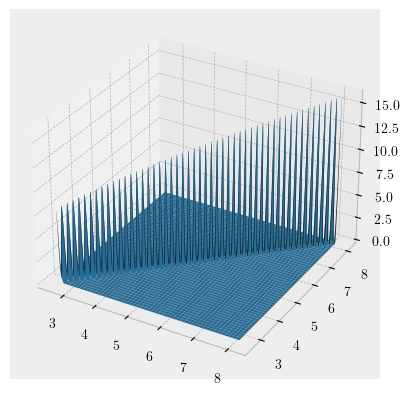

In [6]:
Ei_min = 2.6
Ei_max = 2.6 + 0.425 * 13
u = np.linspace(Ei_min, Ei_max, 1000)
v = np.linspace(Ei_min, Ei_max, 1000)
U, V = np.meshgrid(u, v)
W = R(U, V)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(U, V, W)
plt.show()

In [7]:
dM

0.7823334100000222

In [8]:
R(4 + dM, 4)

2.4786919266966082e-116

### Survival probability

$$
P_{\nu_e \to \nu_e} = 1 - \sin^2 2\theta_{13}
\Big[\cos^2\theta_{12} \sin^2\Delta_{13}
+ \sin^2\theta_{12} \sin^2\Delta_{32}\Big] - P_{\odot},
$$
$$
P_\odot = \sin^2 2\theta_{12} \cos^4 \theta_{13}
\sin^2 \Delta_{21},
$$
onde $\Delta_{ij} = \frac{\Delta m_{ij}^2 L}{4 E}$ são as fases cinéticas.

In [9]:
ordering = 'normal'
dm2_21 = 7.42e-5    # eV^{-2}
dm2_atm = 2.515e-3  # eV^{-2}
if ordering == 'inverted':
    dm2_32 = dm2_atm
else:
    dm2_32 = - dm2_atm - dm2_21
dm2_13 = - dm2_21 - dm2_32

def sci(num):
    return "{:e}".format(num)

def rad(graus):
    return np.pi * graus / 180.0

# parameters from NuFIT
th12 = rad(33.44)
th23 = rad(49.2)
th13 = rad(8.57)
d_cp = rad(194.0)

def P_e0(E, L):
    return 1.0

def P_e(E, L):
    a = 1266.9326791370845 * dm2_21 * L / E
    return 1 - (np.sin(2*th12) * np.sin(a))**2

#def P_e(E, L):
#    d13 = 1266.9326791370845 * dm2_13 * L / E   # 1266.93 is the conversion factor for dm^2 L / 4E
#    d21 = 1266.9326791370845 * dm2_21 * L / E   # E (MeV), L (km), dm2 (eV^2)
#    d32 = 1266.9326791370845 * dm2_32 * L / E
#    p = np.cos(th12)**2 * np.sin(d13)**2 + np.sin(th12)**2 * np.sin(d32)**2
#    p *= - np.sin(2*th13)**2
#    p_o = np.sin(2*th12)**2 * np.cos(th13)**4 * np.sin(d21)**2
#    p += 1 - p_o
#    return p

### Cross section

In [10]:
def nu_exponent(E_nu):
    return -0.07056 + 0.02018*np.log(E_nu)-0.001953*(np.log(E_nu))**3

def cross_sec(E_nu):   # E in MeV
    E_e = E_nu - dM
    p_e = np.sqrt(E_e**2 - m_e**2)
    return 1e-1 * p_e * E_e * E_nu**nu_exponent(E_nu)  # return in 1e+42 cm^2

def cross_sec0(E_nu):   # E in MeV
    E_e = E_nu - dM
    p_e = np.sqrt(E_e**2 - m_e**2)
    return 0.0952 * E_e * p_e  # return in 1e+42 cm^2 (have to multiply it by 1e-42)

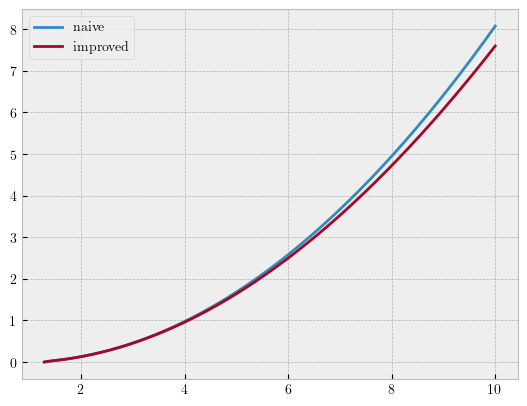

In [11]:
x = np.linspace(dM + m_e, 10, 200)
plt.plot(x, cross_sec0(x), label='naive')
plt.plot(x, cross_sec(x), label='improved')
plt.legend()
plt.show()

## Neutrino fluxes from reactors

$$
\frac{d\Phi}{dE} = \sum_k^{\text{reactors}}
\frac{P_{\text{th}}^k L_F^k}{4\pi d_k^2}
\sum_{i=1}^4 \frac{p_i}{Q_i} \lambda_i(E).
$$

In [12]:
df = pd.DataFrame({'235U':[3.217, -3.111, 1.395, -3.690e-1, 4.445e-2, -2.053e-3],
        '238U':[4.833e-1, 1.927e-1, -1.283e-1, -6.762e-3, 2.233e-3, -1.536e-4],
        '239Pu':[6.413, -7.432, 3.535, -8.820e-1, 1.025e-1, -4.550e-3],
        '241Pu':[3.251, -3.204, 1.428, -3.675e-1, 4.254e-2, -1.896e-3]})
df.loc['Q']    = [202.36, 205.99, 211.12, 214.26]  # 0.26, 0.52, 0.34, 0.33 (incertezas)
df.loc['PWR']  = [ 0.560,  0.080,  0.300, 0.060 ]
df.loc['MOX']  = [ 0.000,  0.081,  0.708, 0.212 ]
df.loc['PHWR'] = [ 0.543,  0.411,  0.022, 0.024 ]
lambd = {}
lambd['235U']  = lambda z: np.exp(sum([df['235U'][j] * z**j for j in range(6)]))
lambd['238U']  = lambda z: np.exp(sum([df['238U'][j] * z**j for j in range(6)]))
lambd['239Pu'] = lambda z: np.exp(sum([df['239Pu'][j] * z**j for j in range(6)]))
lambd['241Pu'] = lambda z: np.exp(sum([df['241Pu'][j] * z**j for j in range(6)]))
df

,235U,238U,239Pu,241Pu
0,3.217000,0.483300,6.41300,3.251000
1,-3.111000,0.192700,-7.43200,-3.204000
2,1.395000,-0.128300,3.53500,1.428000
3,-0.369000,-0.006762,-0.88200,-0.367500
4,0.044450,0.002233,0.10250,0.042540
5,-0.002053,-0.000154,-0.00455,-0.001896
Q,202.360000,205.990000,211.12000,214.260000
PWR,0.560000,0.080000,0.30000,0.060000
MOX,0.000000,0.081000,0.70800,0.212000
PHWR,0.543000,0.411000,0.02200,0.024000


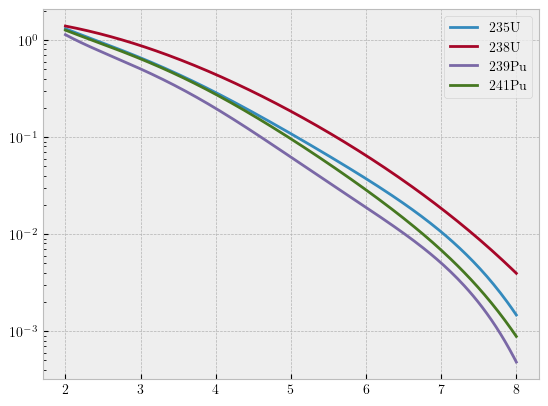

In [13]:
X = np.linspace(2, 8, 200)
for isot in df:
    plt.plot(X, lambd[isot](X), label=isot)
    plt.legend()
plt.yscale('log')
plt.show()

## Getting reactors data

In [14]:
# data taking from March 9, 2002 to January 11, 2004
# 2002 é bissexto
time_0 = 257.3   # days
time_1 = 257.9   # days
life_time = time_0 + time_1

In [15]:
class Reactor:
    def __init__(self, nm, typ, pth, d, LF_2002, LF_2003):
        self.name = nm
        self.type = typ
        self.P_th = pth
        self.dist = d
        self.LF_0 = LF_2002
        self.LF_1 = LF_2003
    def df(self):
        c = ['type', 'P_th (MW)', 'dist (km)', 'LF_0 (%)', 'LF_1 (%)']
        dataf = pd.DataFrame(columns=c)
        dataf.loc[self.name] = [self.type, self.P_th, self.dist,
                           self.LF_0, self.LF_1]
        return dataf
    def LF(self):
        lf = (self.LF_0 * time_0 + self.LF_1 * time_1) / (time_0 + time_1)
        return lf / 100  # because LF was in %
    def p(self, i):
        pwr = {'235U' : 0.560,
               '238U' : 0.080,
               '239Pu': 0.300,
               '241Pu': 0.060, }
        mox = {'235U' : 0.000,
               '238U' : 0.081,
               '239Pu': 0.708,
               '241Pu': 0.212, }
        phwr = {'235U' : 0.543,
                '238U' : 0.411,
                '239Pu': 0.022,
                '241Pu': 0.024, }
        if self.type == 'PHWR':
            return phwr[i]
        elif self.type == 'MOX':
            return mox[i]
        else:
            return pwr[i]


def create_reactor(file_name):
    f = open(file_name, 'r')
    name = f.readline().split()[1]
    typ  = f.readline().split()[1]
    pth  = float(f.readline().split()[1])
    d    = float(f.readline().split()[1])
    f.readline()
    for line in f:
        year = int(line.split()[0])
        if year == 2002:
            break
    LF_2002 = float(line.split()[7])
    LF_2003 = float(f.readline().split()[7])
    f.close()
    return Reactor(name, typ, pth, d, LF_2002, LF_2003)

In [16]:
reactors = []
for file in os.listdir('../3-data/reactors/'):
    if file.endswith('.react'):
        r = create_reactor('../3-data/reactors/' + file)
        reactors.append(r)
reac = pd.concat([r.df() for r in reactors])
reac['average LF (%)'] = [r.LF() * 100 for r in reactors]
print('reactors dataframe shape =', reac.shape)
reac.head(10)

reactors dataframe shape = (70, 6)


,type,P_th (MW),dist (km),LF_0 (%),LF_1 (%),average LF (%)
GENKAI-3,PWR,3423.0,755.0,96.8,87.8,92.294759
TSURUGA-1,BWR,1070.0,138.0,85.2,81.2,83.197671
HANBIT-3,PWR,2825.0,986.0,92.0,93.9,92.951106
KORI-4,PWR,2912.0,735.0,108.4,96.9,102.643304
FUKUSHIMA_DAIICHI-3,BWR,2381.0,349.0,53.6,37.3,45.440509
FUKUSHIMA_DAINI-3,BWR,3293.0,345.0,65.5,0.0,32.711859
HAMAOKA-4,BWR,3293.0,214.0,67.3,39.0,53.133521
WOLSONG-2,PHWR,2061.0,709.0,92.5,96.2,94.352155
FUKUSHIMA_DAIICHI-2,BWR,2381.0,349.0,76.6,24.0,50.269371
GENKAI-1,PWR,1650.0,755.0,82.5,78.2,80.347496


In [17]:
def list_of_emptys(n):
    L = []
    for _ in range(n):
        L.append([])
    return L

In [18]:
pw_plants = []
for r in reactors:
    nm = r.name.split('-')[0]
    if nm not in pw_plants:
        pw_plants.append(nm)
pw_plants = sorted(pw_plants)
cores = np.zeros(20, dtype=int)
p_ths = list_of_emptys(20)
lfs = list_of_emptys(20)
for r in reactors:
    cores[pw_plants.index(r.name.split('-')[0])] += 1
    p_ths[pw_plants.index(r.name.split('-')[0])].append(r.P_th / 1000)
    lfs[pw_plants.index(r.name.split('-')[0])].append(r.LF() * 100)
print(pw_plants)
print(cores)
print()
print([sum(p) for p in p_ths])
print()
print(lfs)

avg_lfs = []
for i in range(20):
    avg = 0
    for j in range(len(p_ths[i])):
        avg += p_ths[i][j] * lfs[i][j]
    avg /= sum(p_ths[i])
    avg_lfs.append(round(avg, 2))
print()
print(avg_lfs)

['FUKUSHIMA_DAIICHI', 'FUKUSHIMA_DAINI', 'GENKAI', 'HAMAOKA', 'HANBIT', 'HANUL', 'IKATA', 'KASHIWAZAKI_KARIWA', 'KORI', 'MIHAMA', 'OHI', 'ONAGAWA', 'SENDAI', 'SHIKA', 'SHIMANE', 'TAKAHAMA', 'TOKAI', 'TOMARI', 'TSURUGA', 'WOLSONG']
[6 4 4 4 6 4 3 7 4 3 4 3 2 1 2 4 1 2 2 4]

[14.197, 13.172, 10.146, 10.615, 16.874, 11.2, 5.960000000000001, 24.316999999999997, 9.434999999999999, 4.927, 13.692, 6.465, 5.32, 1.593, 3.816, 10.2, 3.293, 3.3, 4.481, 8.244]

[[45.44050854037266, 50.269371118012415, 40.502775621118005, 69.91616847826086, 35.15900621118013, 58.289751552795025], [32.71185947204969, 66.71267468944099, 31.962732919254655, 24.821059782608696], [92.29475931677017, 80.34749611801242, 92.75483307453415, 90.55867624223602], [53.133520962732916, 42.31942934782608, 0.0, 50.405958850931675], [92.95110636645963, 54.24402173913043, 97.55646350931676, 91.89743788819875, 98.9442352484472, 91.48707298136645], [90.55425077639751, 73.45657996894408, 85.25553183229812, 89.25657996894408], [77.05250

In [19]:
avg_lfs[pw_plants.index('KORI')]

98.29

In [20]:
def phi(E_nu):
    soma = 0
    for r in reactors:
        a = P_e(E_nu, r.dist) * r.P_th * r.LF() / (4 * np.pi * r.dist**2)
        b = 0
        for i in df:
            b += r.p(i) * lambd[i](E_nu) / df.loc['Q'][i]
        soma += a * b
    return soma

def phi0(E_nu):
    soma = 0
    for r in reactors:
        a = P_e0(E_nu, r.dist) * r.P_th * r.LF() / (4 * np.pi * r.dist**2)
        b = 0
        for i in df:
            b += r.p(i) * lambd[i](E_nu) / df.loc['Q'][i]
        soma += a * b
    return soma

In [21]:
days = 24 * 60 * 60 # in seconds
elec_charge = 1.60217663e-19  # electron charge in coulombs
M = 1e-42 * N_T * 1e-10 * days / elec_charge  # constant to make units right
def func(E, Ei):  # f(y, x)
    #E_nu = E + dM
    return M * phi(E) * cross_sec(E) * R(E, Ei)  # magic fator = 0.706
    #return M * phi(E_nu) * cross_sec(E_nu) * R(E, Ei)
def func0(E, Ei):  # f(y, x)
    #E_nu = E + dM
    return M * phi0(E) * cross_sec(E) * R(E, Ei)  # magic fator = 0.706
    #return M * phi0(E_nu) * cross_sec(E_nu) * R(E, Ei)

In [22]:
Ei_min = 2.6 + dM
Ei_max = Ei_min + 0.425 * 13
print('Ei_min =', Ei_min)
print('Ei_max =', Ei_max)
## integrating on [-6 sigma, 6 sigma] because that is sufficient and faster
#N = dblquad(func, Ei_min, Ei_max, lambda x: x-6*sig(x), lambda x: x+6*sig(x))
#print('N =', N)
#N0 = dblquad(func0, Ei_min, Ei_max, lambda x: x-6*sig(x), lambda x: x+6*sig(x))
#print('N0 =', N0)
## out: N = (236.756786458965, 1.4705727080510655e-08)

Ei_min = 3.3823334100000224
Ei_max = 8.907333410000021


In [23]:
if run == True:
    dbin = 0.425
    Erang = []
    simul0 = []
    for j in range(0, 13):
        Ei_min = 2.6 + dM + j * dbin
        Ei_max = Ei_min + dbin
        Erang.append((Ei_min + Ei_max)/2)
        N0 = dblquad(func0, Ei_min, Ei_max, lambda x: x-6*sig(x), lambda x: x+6*sig(x))
        print('N0 =', N0[0])
        simul0.append(N0[0])
    simul0 = np.array(simul0)
else:
    simul0 = np.array([77.57047468959513, 70.18294361238667, 59.4243619678977, 47.83994413917073, 37.07311806462947, 27.826933829868217, 20.18000204256307, 13.940890205827836, 8.913630738925312, 5.042334290335754, 2.384323940405243, 0.8979512318417864, 0.27195551374830473])

In [24]:
print(list(simul0))

[77.57047468959513, 70.18294361238667, 59.4243619678977, 47.83994413917073, 37.07311806462947, 27.826933829868217, 20.18000204256307, 13.940890205827836, 8.913630738925312, 5.042334290335754, 2.384323940405243, 0.8979512318417864, 0.27195551374830473]


In [25]:
# simul0 = [77.57047468959513, 70.18294361238667, 59.4243619678977, 47.83994413917073, 37.07311806462947,
#           27.826933829868217, 20.18000204256307, 13.940890205827836, 8.913630738925312, 5.042334290335754,
#           2.384323940405243, 0.8979512318417864, 0.27195551374830473]

In [26]:
if run == True:
    dbin = 0.425
    Erang = []
    simul = []
    for j in range(0, 13):
        Ei_min = 2.6 + dM + j * dbin
        Ei_max = Ei_min + dbin
        Erang.append((Ei_min + Ei_max)/2)
        N = dblquad(func, Ei_min, Ei_max, lambda x: x-6*sig(x), lambda x: x+6*sig(x))
        print('N =', N[0])
        simul.append(N[0])
    simul = np.array(simul)
else:
    simul = np.array([35.097256495568196, 39.88713352643623, 42.85251891951071, 37.92194261194101, 30.035646401253693, 20.947971448139004, 13.08743526606502, 7.732717427156728, 4.3463669387310215, 2.1583623850765368, 0.8807697802277841, 0.2883706109150266, 0.07947201433531714])

In [27]:
print(list(simul))

[35.097256495568196, 39.88713352643623, 42.85251891951071, 37.92194261194101, 30.035646401253693, 20.947971448139004, 13.08743526606502, 7.732717427156728, 4.3463669387310215, 2.1583623850765368, 0.8807697802277841, 0.2883706109150266, 0.07947201433531714]


In [28]:
# simul = np.array([35.097256495568196, 39.88713352643623, 42.85251891951071,
#                   37.92194261194101, 30.035646401253693, 20.947971448139004,
#                   13.08743526606502, 7.732717427156728, 4.3463669387310215,
#                   2.1583623850765368, 0.8807697802277841, 0.2883706109150266, 0.07947201433531714])

In [29]:
bg = pd.read_csv('BG-Spectrum.dat', names=[0, 1, 2, 3], sep=' ')
bg = bg[bg[0] >= 2.6]
bg[0] += dM
bg.index -= bg.index[0]
for c in [1,2,3]:
    bg[c] *= simpson(bg[c], bg[0]) / bg[c].sum()
print('shape =', bg.shape)
bg.head(10)

shape = (741, 4)


,0,1,2,3
0,3.382333,0.004720,0.087125,0.049637
1,3.392333,0.004739,0.089851,0.048497
2,3.402333,0.004759,0.094140,0.047392
3,3.412333,0.004778,0.098430,0.046319
4,3.422333,0.004798,0.098464,0.045277
5,3.432333,0.004817,0.098499,0.044264
6,3.442333,0.004837,0.101261,0.043279
7,3.452333,0.004857,0.104022,0.042319
8,3.462333,0.004876,0.105202,0.041383
9,3.472333,0.004896,0.106383,0.040470


In [30]:
Ei_min = 2.6 + dM
Ei_max = Ei_min + 16 * 0.425
bins = np.linspace(Ei_min, Ei_max, 13)
dig = np.digitize(bg[0], bins)
backg = []
for c in [1,2,3]:
    backg.append(np.array([sum([bg[c][i] for i in range(len(bg[0])) if dig[i] == k]) for k in range(1,14)]))
    print(f'b[{c}] =', backg[c-1])
    print(f'b[{c}].sum() =', backg[c-1].sum())
    print()
tbg = sum(backg)
print('tbg =', tbg)
print('tbg.sum() =', tbg.sum())

b[1] = [0.29973769 0.35734478 0.40478753 0.43164802 0.45976503 0.46507144
 0.44695332 0.4299042  0.39090832 0.33469746 0.28171155 0.21388452
 0.16148953]
b[1].sum() = 4.677903400000001

b[2] = [2.60764155e+00 6.03116795e-02 8.02303214e-03 2.36175626e-03
 2.13600016e-03 1.91024367e-03 2.08390272e-03 1.71921985e-03
 1.89287880e-03 1.99707221e-03 1.94497546e-03 1.51082930e-03
 8.50927051e-04]
b[2].sum() = 2.694384068000026

b[3] = [1.53079115e+00 1.01116920e-01 1.11715071e-02 1.24192636e+00
 5.93846711e-01 2.65261628e+00 4.29278421e+00 3.50337680e-02
 1.82310029e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
b[3].sum() = 10.459287083955992

tbg = [4.43817039 0.51877338 0.42398207 1.67593613 1.05574774 3.11959796
 4.74182144 0.46665719 0.39280138 0.33669453 0.28365652 0.21539535
 0.16234046]
tbg.sum() = 17.831574551956017


simul0.sum() = 371.5488642671952
simul.sum() + tbg.sum() = 253.1475383773123


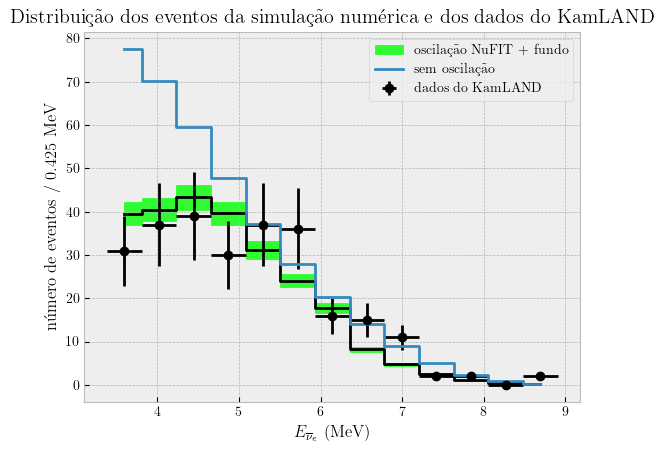

In [53]:
Ei_min = 2.6 + dM
Ei_max = Ei_min + 0.425 * 13
bins = np.linspace(Ei_min, Ei_max, 14)
midbins = (bins[1:] + bins[:-1]) / 2
print('simul0.sum() =', simul0.sum())
print('simul.sum() + tbg.sum() =', simul.sum() + tbg.sum())
err = 0.065 * (simul + tbg)
#plt.step(midbins, simul+tbg, where='mid', linewidth=15, color='lime')
plt.fill_between(midbins, simul+tbg-err, simul+tbg+err,
                 step='mid', color='lime', alpha=0.8, label='oscilação NuFIT + fundo')
plt.step(midbins, simul + tbg, where='mid', color='k')
plt.errorbar(midbins, energ_vc, xerr=0.425/2, yerr=0.26*energ_vc,
             marker='o', linestyle='', color='k', label='dados do KamLAND')
plt.step(midbins, simul0, where='mid', label='sem oscilação')
plt.xlabel(r'$E_{\overline{\nu}_e}$ (MeV)')
plt.ylabel(r'número de eventos / 0.425 MeV')
plt.title(r'Distribuição dos eventos da simulação numérica e dos dados do KamLAND')
plt.legend()
plt.savefig('index.png', dpi=300, format='png', bbox_inches='tight')
plt.show()

In [32]:
#N0 = (331.7977375618153, 7.518156570635078e-07)

In [33]:
#print(N[0], '+-', 0.08 * N[0])
#print(N0[0], '+-', 0.08 * N0[0])
#print(N[0] / N0[0], '+-', 0.08 * N[0]/N0[0])

In [34]:
# 258 - 17.8 = 240.2
# 334 * 0.706 = 235.8
# 530 * 0.706 = 374.2
# other good factor is 0.715